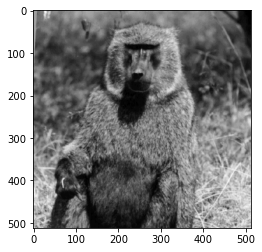

In [1]:
import os 
# os.chdir(r"E:\ENMARTZ\SEMESTRE 10\Optimización Convexa\Proyecto\admm-matrix-completion")
os.chdir(r"G:\Mi unidad\2021-I\optimizacion\admm-matrix-completion")

from data import load_gif_data
from core.utils import Mask
    
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)

DATA_DIR = "imgs/validation"
dataset = load_gif_data(DATA_DIR) / 255
img = dataset[0]

plt.imshow(img, cmap='gray')

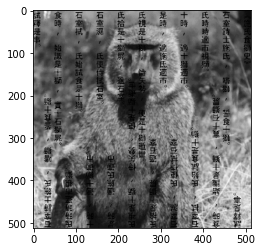

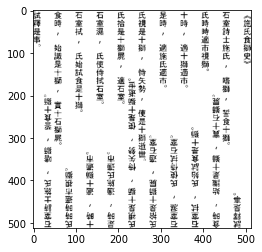

In [2]:
MODE = "text"
mask = Mask(mode=MODE, prcnt=0.5)

corrupted , mask = mask(img)
plt.imshow(corrupted, cmap='gray')
plt.show()

plt.imshow(mask, cmap='gray')
plt.show()

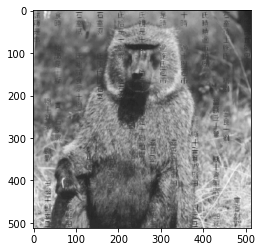

In [3]:
import bm3d

denoised = bm3d.bm3d(corrupted, sigma_psd=np.std(mask), stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
plt.imshow(denoised*(1-mask)+ corrupted, cmap='gray')

Text(0.5, 0, 'lambda')

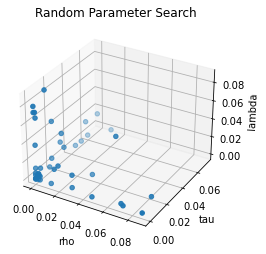

In [4]:
# Random parameter search. https://napsterinblue.github.io/notes/machine_learning/model_selection/random_search/

# log scale

min_exp, max_exp = -5, -1

np.random.seed(5)
rhos = 10 ** np.random.uniform(min_exp, max_exp, size=50)
taus = 10 ** np.random.uniform(min_exp, max_exp, size=50)
lams = 10 ** np.random.uniform(min_exp, max_exp, size=50)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(rhos, taus, lams)
ax.set_title('Random Parameter Search')
ax.set_xlabel('rho')
ax.set_ylabel('tau')
ax.set_zlabel('lambda')

Iteration [50 / 50] rho: 0.001534 tau: 0.000442 lambda: 0.004342: 100%|██████████| 50/50 [03:54<00:00,  4.70s/it, frob=31.1, psnr=24.3, ssim=0.82]


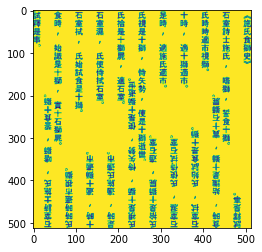

In [5]:
# from itertools import product
from core.admm_v2 import ADMM

iters = 50
mask_names = ["text"]

for mask_name in mask_names:
    for i, (rho, tau, lambd) in enumerate(zip(rhos, taus, lams)):
        history = []
        path = f'results/exp_{i}_mask_{mask_name}_rho_{np.round(rho, 6)}_tau_{np.round(tau, 6)}_lambda_{np.round(lambd, 6)}.txt'

        for img in dataset:

            params = dict(rho=rho,
                        tau=tau,
                        lambd=lambd,
                        iters=iters
                        )

            mask = Mask(mode=mask_name, prcnt=0.5)
            corrupted, mask = mask(img)

            plt.imshow(mask)

            admm = ADMM()
            estimated, hist = admm.restore(corrupted, mask, sol=img, **params)
            history.append(hist)

        frob_list = []
        psnr_list = []
        ssim_list = []
        with open(path, "w") as txt:
            txt.write("#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#\n")
            txt.write("      Model configuration and hyperparameters      \n")
            txt.write("#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#\n")
            txt.write(f"mask_{mask_name}\trho_{rho}\ttau_{tau}\tlambda_{lambd}\n")
            for his in history:
                frob, psnr, ssim = his["frob"], his["psnr"], his["ssim"]
                txt.write(f'frob={frob}\tpsnr={psnr}\tssim={ssim}\n')
                frob_list.append(frob)
                psnr_list.append(psnr)
                ssim_list.append(ssim)
            txt.write('Promedio:\n')
            mean_frob, mean_psnr, mean_ssim = np.mean(frob_list), np.mean(psnr_list), np.mean(ssim_list)
            txt.write(f'frob={mean_frob}\tpsnr={mean_psnr}\tssim={mean_ssim}\n')


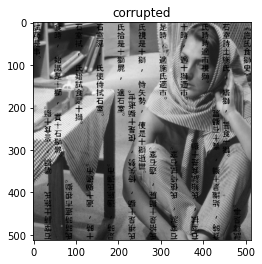

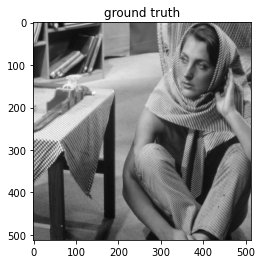

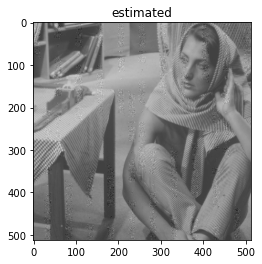

In [6]:
plt.title("corrupted")
plt.imshow(corrupted, cmap='gray')
plt.show()

plt.title("ground truth")
plt.imshow(img, cmap='gray')
plt.show()


plt.title("estimated")
plt.imshow(estimated, cmap='gray')
plt.show()

In [7]:
# ! pip install bm3d
# ! pip install scikit-image
# ! pip install tqdm